# Two qubit gates modeled with two three-level transmons coupled via resonator

https://journals.aps.org/pra/pdf/10.1103/PhysRevA.101.052308
The two transmon model used here is presented in Eq. 2.12 of  PHYSICAL REVIEW A 101, 052308 (2020).

In [52]:
import numpy as np
import qiskit.pulse as pulse
from matplotlib import pyplot as plt
from qiskit_dynamics.pulse import InstructionToSignals
from qiskit.quantum_info.operators import Operator
from qiskit_dynamics import Solver, Signal
from matplotlib import pyplot as plt
from qiskit.quantum_info.states import Statevector
from scipy.optimize import minimize, minimize_scalar
from scipy.linalg import expm
import sympy as sym
import jax
jax.config.update("jax_enable_x64", True)

# tell JAX we are using CPU
jax.config.update('jax_platform_name', 'cpu')

import jax.numpy as jnp
from jax import jit, value_and_grad

In [2]:
#Plot code
from mpl_toolkits.axes_grid1 import AxesGrid
def heatmap2d(arr: np.ndarray):
    # define axes grid
    fig = plt.figure(frameon=False,figsize=(12, 8))
    fig.subplots_adjust(top=0.95)
    grid = AxesGrid(
        fig, 111, 
        nrows_ncols=(1, 2),
        axes_pad=0.5,
        cbar_mode='each',
        cbar_location='right',
        cbar_pad=0.1
    )   
    # plot 
    real_image = grid[0].imshow(np.real(arr), cmap='plasma')
    grid[0].set_title("Real Part of matrix, $\Re{(M)}$", fontsize=20)
    imag_image = grid[1].imshow(np.imag(arr), cmap='plasma')
    grid[1].set_title("Imaginary Part of matrix, $\Im{(M)}$", fontsize=20)
    cbar = grid.cbar_axes[0].colorbar(real_image)
    cbar = grid.cbar_axes[1].colorbar(imag_image)
    plt.show()

In [3]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService(channel='ibm_quantum', instance="ibm-q/open/main")
backend = service.backend("ibm_sherbrooke")

qubit_num1 = 74
qubit_num2 = 89

w1 = backend.qubit_properties(qubit_num1).frequency * 1E-9 #GHz, qubit frequency
w2 = backend.qubit_properties(qubit_num2).frequency * 1E-9

d1 = backend.qubit_properties(qubit_num1).anharmonicity * 1E-9 #GHz, anharmonicity
d2 = backend.qubit_properties(qubit_num2).anharmonicity * 1E-9 #GHz, anharmonicity

b1 = - 1 / (2 * d1) #ns, DRAG derivative strength
b2 = - 1 / (2 * d2) #ns, DRAG derivative strength

Δ12 = w1 - w2 #GHz, qubit detuning


dt = backend.dt * 1E9 #ns, AWG sample time
dur = int(backend.target["sx"][(qubit_num1,)].duration * 1E9 / dt) #dt, single gate pulse duration
σ = dur / 4 #convention that duration is 4 sigma
n = 3 #3 level system
r = 0.1 #GHz, rabi frequency 

ecr_dur = backend.target["ecr"][(89, 74)].duration * 1E9 / dt
x_dur = backend.target["x"][(74,)].duration * 1E9 / dt
rzx_dur = dur2 = int((ecr_dur - x_dur)/2)
rzx_dur

1072

In [93]:
class Transmon:
    def __init__(self, qubit_freq, anharmonicity, rabi_strength, pulse_duration, dt):
        self.w = qubit_freq #GHz
        self.d = anharmonicity #GHz
        self.r = rabi_strength #GHz
        self.dur = pulse_duration #units of dt
        self.β = - 1 / (2 * self.d) #ns
        self.σ = self.dur / 4 #dt
        self.dt = dt #ns
        n = 3 #3 level model

        # construct the solver
        self.hamiltonian_solver = Solver(
            static_hamiltonian=Operator(Transmon.H_transmon(n, self.w, self.d)),
            hamiltonian_operators=[Operator(Transmon.H_drive(n, self.r))],
            rotating_frame=Operator(Transmon.H_transmon(n, self.w, self.d)),
            rwa_carrier_freqs=[self.w],
            #rwa_cutoff_freq=2 * self.w,
            array_library='jax',
            hamiltonian_channels=['d0'],
            channel_carrier_freqs={'d0': self.w},
            dt= self.dt
        )

    @classmethod
    def change_num_levels(cls, num: int):
        n = num

    #Hamiltonian helper functions
    # Standard Nonlinear Oscillator (Duffing) Hamiltonian    
    @staticmethod
    def H_transmon(max_j, w, d):
        H = np.zeros((max_j, max_j))
        for j in range(max_j):
            H[j,j] = 2*np.pi* ( (w - d/2)*(j) + (d/2)*(j**2) - w/2)
        return H
    
    #X drive hamiltonian
    @staticmethod
    def H_drive(max_j, r):
        H = np.zeros((max_j, max_j))
        for j in range(max_j - 1):
            #λ_1 = sqrt(2)
            H[j,j+1] = np.sqrt(j+1)
            H[j+1,j] = np.sqrt(j+1)
        return 2*np.pi * (r / 2) * H


    #JAX compatible lifted gaussian pulse
    @staticmethod
    def lifted_gaussian(
        t: sym.Symbol,
        center,
        t_zero,
        sigma,
    ) -> sym.Expr:
        t_shifted = (t - center).expand()
        t_offset = (t_zero - center).expand()

        gauss = sym.exp(-((t_shifted / sigma) ** 2) / 2)
        offset = sym.exp(-((t_offset / sigma) ** 2) / 2)

        return (gauss - offset) / (1 - offset)


    #JAX compatible drag pulse
    @staticmethod
    def drag(params):
        amp, sigma, beta, duration = params
        _t, _duration, _amp, _sigma, _angle, _beta = sym.symbols("t, duration, amp, sigma, angle, beta")
        _center = _duration / 2
        envelope_expr = (_amp * sym.exp(sym.I * _angle) * Transmon.lifted_gaussian(_t, _center, _duration + 1, _sigma)
                        * (1+ 1j * _beta * (_t - _center)/(_sigma**2)))

        pulse.ScalableSymbolicPulse.disable_validation = True
        return pulse.ScalableSymbolicPulse(
                pulse_type="DRAG",
                duration= duration,
                angle=0,
                amp=amp,
                parameters={"sigma": sigma, "beta": beta},
                envelope=envelope_expr,
                constraints=sym.And(_sigma > 0, _beta > 0),
                valid_amp_conditions=sym.Abs(_amp) <= 1.0,
            )

    @staticmethod
    def ideal_RX(θ):
        return jnp.array([[np.cos(θ/2), -1j*np.sin(θ/2), 0],
                        [-1j*np.sin(θ/2), np.cos(θ/2), 0],
                        [0, 0, 1]])

    @staticmethod
    def ideal_H():
        return (1/np.sqrt(2))*np.array([[1, 1, 0],
                        [1, -1, 0],
                        [0, 0, 1]])

    @staticmethod
    def fidelity(ideal_gate , U):
        return jnp.abs(jnp.trace(ideal_gate.conj().T @ U))**2 / n**2
    

    def single_transmon_objective(self, amp, θ):
        #generate rx pulse schedule  
        with pulse.build(name="RX") as r_x:
            pulse.play(Transmon.drag([amp, self.σ, self.β, self.dur]), pulse.DriveChannel(0))

        #solve dynamics
        sol = self.hamiltonian_solver.solve(t_span=[0., self.dur*self.dt], y0=jnp.eye(3, dtype=complex), 
                                        method='jax_odeint', signals=r_x, atol=1e-8, rtol=1e-8)

        u = sol.y[-1]
        return 1. - Transmon.fidelity(Transmon.ideal_RX(θ), u)


    def opt_RX(self, θ, x0=0.1634):
        opt_results = minimize_scalar(self.single_transmon_objective, args=(θ), bounds=(0.,1.))
        #Optionally, can use JAX compilation for optimization - not much faster for single variable
        #jit_grad_obj = jit(value_and_grad(single_transmon_objective))
        #opt_results = minimize(fun=jit_grad_obj, x0= x0, jac=True, method='BFGS')

        #generate rx pulse schedule  
        with pulse.build(name="RX") as r_x:
            pulse.play(self.drag([opt_results.x.item(), self.σ, self.β, self.dur]), pulse.DriveChannel(0))
        
        return opt_results, r_x
    
    def hadamard(self, x0=0.1634):
        opt_results_ = minimize_scalar(self.single_transmon_objective, args=(np.pi/2), bounds=(0.,1.))
        #opt_results2 = minimize_scalar(self.single_transmon_objective, args=(np.pi), bounds=(0.,1.))
        with pulse.build(name="Hadamard") as hgate:
            pulse.shift_phase(np.pi/2, pulse.DriveChannel(0))
            pulse.play(self.drag([opt_results_.x.item(), self.σ, self.β, self.dur]), pulse.DriveChannel(0))
            pulse.shift_phase(np.pi/2, pulse.DriveChannel(0))
            #pulse.play(drag([opt_results_.x, self.σ, self.β, self.dur]), pulse.DriveChannel(0))
        return hgate

    #initial state can be a statevector or operator
    def solve_dynamics(self, initial_state, gate_pulse, plot_pops=True, JAXmethod = False):
        #solve dynamics
        if JAXmethod == True:
            sol = self.hamiltonian_solver.solve(t_span=[0., self.dur*self.dt], method='jax_odeint',
                                            y0 = initial_state, signals=gate_pulse, atol=1e-8, rtol=1e-8)
        else:
            # construct the solver
            non_jax_solver = Solver(
                static_hamiltonian=Operator(Transmon.H_transmon(n, self.w, self.d)),
                hamiltonian_operators=[Operator(Transmon.H_drive(n, self.r))],
                rotating_frame=Operator(Transmon.H_transmon(n, self.w, self.d)),
                rwa_carrier_freqs=[self.w],
                #rwa_cutoff_freq=2 * self.w,
                #array_library='jax',
                hamiltonian_channels=['d0'],
                channel_carrier_freqs={'d0': self.w},
                dt= self.dt
            )
            sol = non_jax_solver.solve(t_span=[0., self.dur*self.dt], 
                                            y0 = initial_state, signals=gate_pulse, atol=1e-8, rtol=1e-8)
            
        if plot_pops: Transmon.plot_populations(sol, self.dur*self.dt)
        return sol
    
    #Plot code
    @staticmethod    
    def plot_populations(sol, max_t):
        pop0 = [psi.probabilities()[0] for psi in sol.y]
        pop1 = [psi.probabilities()[1] for psi in sol.y]
        pop2 = [psi.probabilities()[2] for psi in sol.y]


        fig = plt.figure(figsize=(8, 5))
        plt.plot(sol.t, pop0, lw=3, label="Population in |0>")
        plt.plot(sol.t, pop1, lw=3, label="Population in |1>")
        plt.plot(sol.t, pop2, lw=3, label="Population in |2>")
        plt.xlabel("Time (ns)")
        plt.ylabel("Population")
        plt.legend(frameon=False)
        plt.ylim([0, 1.05])
        plt.xlim([0, max_t])
        plt.grid()
        #plt.vlines(T, 0, 1.05, "k", linestyle="dashed")

In [150]:
class Transmon_System:
    def __init__(self, q1: Transmon, q2: Transmon, J, dur) -> None:
        self.q1 = q1
        self.q2 = q2
        self.J = J
        #self.Ω = Ω
        self.rzx_dur = dur
        self.dt = q1.dt
        self.H_system = Transmon_System.H_sys(q1.w, q2.w, q1.d, q2.d, J)
        self.H_d_q1 = Transmon_System.H_drive_q1(self.q1.r)
        self.H_d_q2 = Transmon_System.H_drive_q2(self.q2.r)

        dressed_energies = np.linalg.eigh(self.H_system)[0]
        #If statement ensures we have E_11 - E_10 + E_01 - E_00 because dressing the states messes up their kronecker ordering.
        #w_d is the drive frequency on the control transmon (transmon 1)
        if q1.w < q2.w:
            self.w_d = 0.5 * (dressed_energies[5] - dressed_energies[1] + dressed_energies[2] - dressed_energies[0]) / (2 * np.pi)
        else:
            self.w_d = 0.5 * (dressed_energies[5] - dressed_energies[2] + dressed_energies[1] - dressed_energies[0]) / (2 * np.pi)

        
        self.R = 2*np.pi*self.w_d*np.array([0, 1, 2, 1, 2, 3, 2, 3, 4])
        # construct the solver
        self.CR_solver = Solver(
            static_hamiltonian=Operator(self.H_system),
            hamiltonian_operators=[Operator(self.H_d_q1)],
            rotating_frame=self.R,
            #array_library='jax',
            rwa_cutoff_freq=2 * self.w_d,
            rwa_carrier_freqs= [self.w_d],
            hamiltonian_channels=['d0'],
            channel_carrier_freqs={'d0': self.w_d},
            dt=self.dt
        )

    def H_sys(w, w2, d, d2, J):
        bdag = (np.array([[0, 0, 0], [1, 0, 0], [0, np.sqrt(2), 0]]))
        interaction = np.kron(bdag, np.eye(3)) @ np.kron(np.eye(3), bdag.T) + np.kron(bdag.T, np.eye(3)) @ np.kron(np.eye(3), bdag)
        return np.kron(Transmon.H_transmon(n, w, d), np.eye(3)) +  np.kron(np.eye(3),Transmon.H_transmon(n, w2, d2)) + 2*np.pi*J*interaction

    def H_drive_q1(r):
        return np.kron(Transmon.H_drive(n, r), np.eye(3))
    
    def H_drive_q2(r):
        return np.kron(np.eye(3), Transmon.H_drive(n, r))

    def plot_two_qubit_populations(sol, max_t):
        pop00 = [psi.probabilities()[0] for psi in sol.y]
        pop01 = [psi.probabilities()[1] for psi in sol.y]
        pop02 = [psi.probabilities()[2] for psi in sol.y]
        pop10 = [psi.probabilities()[3] for psi in sol.y]
        pop11 = [psi.probabilities()[4] for psi in sol.y]
        pop12 = [psi.probabilities()[5] for psi in sol.y]
        pop20 = [psi.probabilities()[6] for psi in sol.y]
        pop21 = [psi.probabilities()[7] for psi in sol.y]
        pop22 = [psi.probabilities()[8] for psi in sol.y]


        fig = plt.figure(figsize=(8, 5))
        plt.plot(sol.t, pop00, lw=3, label="|00>")
        plt.plot(sol.t, pop01, lw=3, label="|01>")
        plt.plot(sol.t, pop02, lw=3, label="|02>")
        plt.plot(sol.t, pop10, lw=3, label="|10>")
        plt.plot(sol.t, pop11, lw=3, label="|11>")
        plt.plot(sol.t, pop12, lw=3, label="|12>")
        plt.plot(sol.t, pop20, lw=3, label="|20>")
        plt.plot(sol.t, pop21, lw=3, label="|21>")
        plt.plot(sol.t, pop22, lw=3, label="|22>")

        plt.xlabel("Time (ns)")
        plt.ylabel("Population")
        plt.legend(frameon=False)
        plt.ylim([0, 1.05])
        plt.xlim([0, max_t])
        plt.grid()
        #plt.vlines(T, 0, 1.05, "k", linestyle="dashed")
    
        
    def solve_CR_dynamics(self, initial_state, gate_pulse, plot_pops=True, JAXmethod = False, plot_matrix=True):
        #solve dynamics
        if JAXmethod == True:
            sol = self.CR_solver.solve(t_span=[0., self.rzx_dur*self.dt], method='jax_odeint',
                                            y0 = initial_state, signals=gate_pulse, atol=1e-8, rtol=1e-8)
        else:
            sol = self.CR_solver.solve(t_span=[0., self.rzx_dur*self.dt], 
                                            y0 = initial_state, signals=gate_pulse, atol=1e-8, rtol=1e-8)
        if plot_pops: Transmon_System.plot_two_qubit_populations(sol, self.rzx_dur*self.dt)
        if (type(initial_state) ==  np.ndarray and plot_matrix): heatmap2d(sol.y[-1])
        return sol
    
    def ideal_ZX(θ):
        Z = np.array([[-1, 0, 0], [0, 1, 0], [0, 0, 1]], dtype=complex)
        X = np.array([[0, 1, 0], [1, 0, 0], [0, 0, 1]], dtype=complex)
        return expm(-0.5j*θ * np.kron(Z, X))
    
    def ideal_RXI(θ):
        return jnp.kron(Transmon.ideal_RX(θ), jnp.eye(3, dtype=complex))
    
    @staticmethod
    def fidelity(ideal_gate , U):
        return jnp.abs(jnp.trace(ideal_gate.conj().T @ U))**2 / (n*n)**2


transmon1 = Transmon(w1, d1, 0.3, dur, dt)
transmon2 = Transmon(w2, d2, 0.3, dur, dt)

system = Transmon_System(transmon1, transmon2, J=0.004, dur=rzx_dur)


Rough driving of an X gate on qubit 2 using CR gate

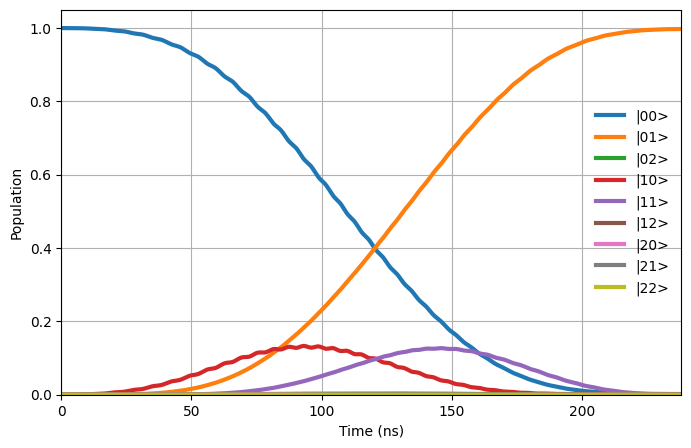

In [114]:
with pulse.build() as twoq_drag_pi:
    pulse.play(Transmon.drag([1., rzx_dur/4, b1, rzx_dur]), channel=pulse.DriveChannel(0),)

gs_00 = Statevector([1.0,0,0,0,0,0,0,0,0])
CRsol_pi = system.solve_CR_dynamics(initial_state=gs_00, gate_pulse=twoq_drag_pi)

Rough ZX(-pi/2) gate using CR

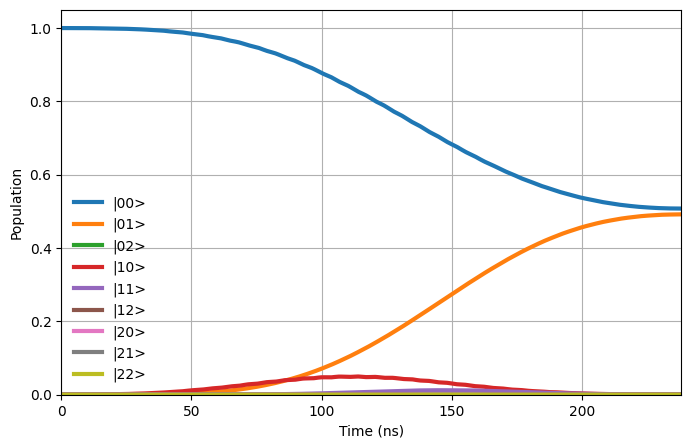

In [91]:
with pulse.build() as twoq_drag_pi2:
    pulse.play(Transmon.drag([0.45, rzx_dur/4, b1, rzx_dur]), channel=pulse.DriveChannel(0),)

gs_00 = Statevector([1.0,0,0,0,0,0,0,0,0])
CRsol_pi2 = system.solve_CR_dynamics(initial_state=gs_00, gate_pulse=twoq_drag_pi2)

c:\Users\kapil\OneDrive - Stanford\Desktop\quantum computing\.venv\lib\site-packages\qiskit_dynamics\solvers\solver_classes.py:525: UserWarning: Attempting to internally JAX-compile simulation of schedules, with Solver.model.array_library not in ["numpy", "jax", "jax_sparse"]. If an error is not raised, explicitly set array_library at Solver instantation to one of these options to remove this warning.
  warn(


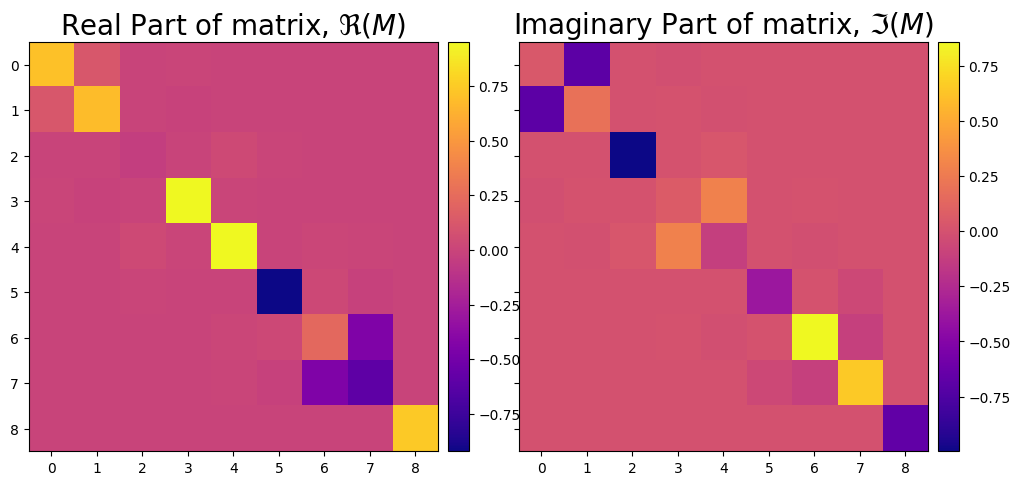

In [115]:
CRsol = system.solve_CR_dynamics(initial_state=np.eye(9, dtype=complex), gate_pulse=twoq_drag_pi2, JAXmethod=True, plot_pops=False)
#heatmap2d(CRsol.y[-1])
#basis: {00, 01, 02, 10, 11, 12, 20, 21, 22}

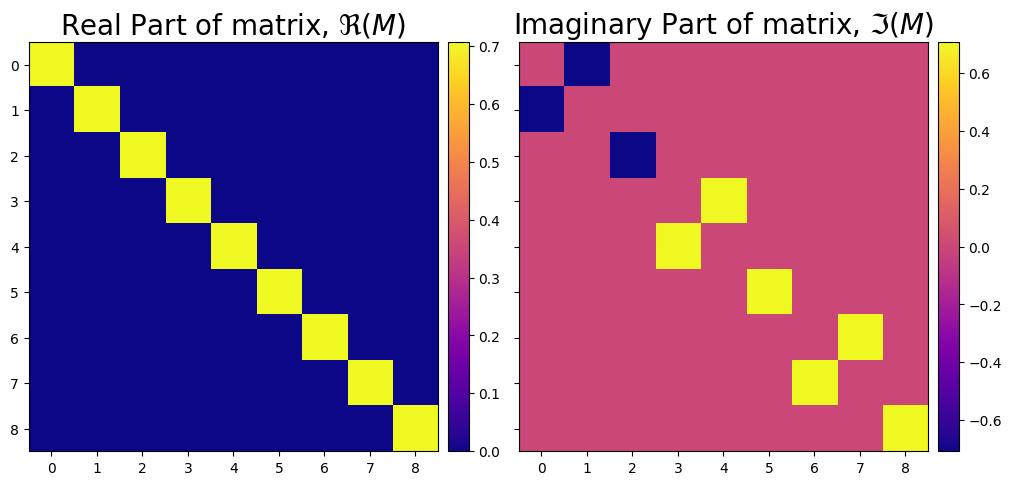

In [120]:
heatmap2d(Transmon_System.ideal_ZX(-np.pi/2))

In [151]:
Transmon_System.fidelity(Transmon_System.ideal_ZX(-np.pi/2), CRsol.y[-1]).item()

0.12521027944286872

Prototype of driving an SX gate on qubit 1 in the coupled system

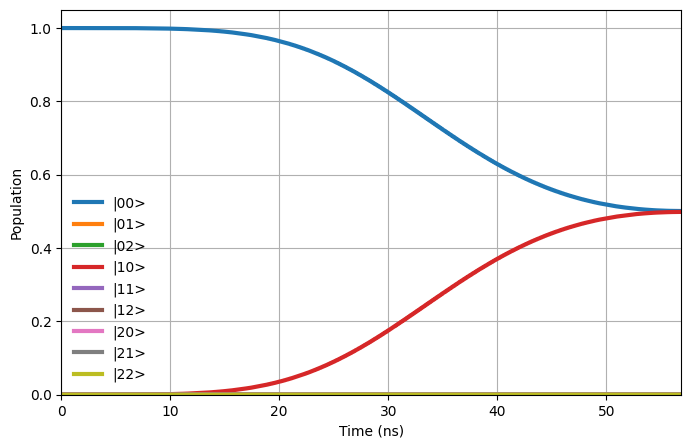

In [143]:
transmon1 = Transmon(w1, d1, 0.1, dur, dt)
transmon2 = Transmon(w2, d2, 0.1, dur, dt)

system = Transmon_System(transmon1, transmon2, J=0.004, dur=rzx_dur)

q1_SX_solver = Solver(
    static_hamiltonian=Operator(system.H_system),
    hamiltonian_operators=[Operator(system.H_d_q1)],
    rotating_frame=Operator(system.H_system),
    #rotating_frame=Operator(w * np.array([0, 1, 2, 1, 2, 3, 2, 3, 4])),
    #rwa_cutoff_freq=2 * w,
    rwa_carrier_freqs= [system.q1.w],
    hamiltonian_channels=['d0'],
    channel_carrier_freqs={'d0': system.q1.w},
    dt=dt
)

with pulse.build() as q1_drag:
    pulse.play(Transmon.drag([0.16343, system.q1.dur/4, system.q1.β, system.q1.dur]), channel=pulse.DriveChannel(0),)


SX_q1_sol00 = q1_SX_solver.solve(t_span=[0,system.q1.dur*system.dt], y0=Statevector([1.0,0,0,0,0,0,0,0,0]), signals=q1_drag, atol=1e-8, rtol=1e-8)
Transmon_System.plot_two_qubit_populations(sol=SX_q1_sol00, max_t=system.q1.dur*system.dt)

c:\Users\kapil\OneDrive - Stanford\Desktop\quantum computing\.venv\lib\site-packages\qiskit_dynamics\solvers\solver_classes.py:525: UserWarning: Attempting to internally JAX-compile simulation of schedules, with Solver.model.array_library not in ["numpy", "jax", "jax_sparse"]. If an error is not raised, explicitly set array_library at Solver instantation to one of these options to remove this warning.
  warn(


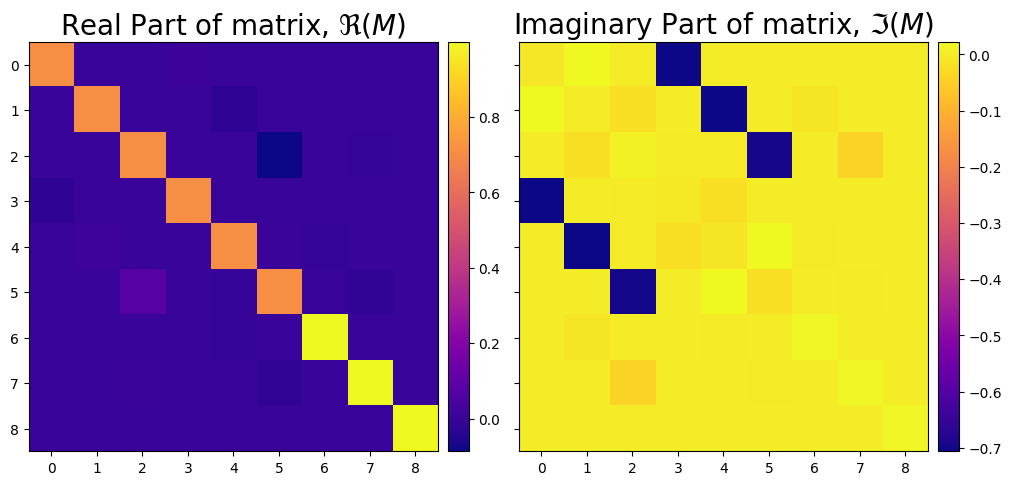

In [146]:
SX_q1_sol00 = q1_SX_solver.solve(t_span=[0,system.q1.dur*system.dt], y0=np.eye(9, dtype=complex), 
                                 signals=q1_drag,method='jax_odeint', atol=1e-8, rtol=1e-8)

heatmap2d(SX_q1_sol00.y[-1])

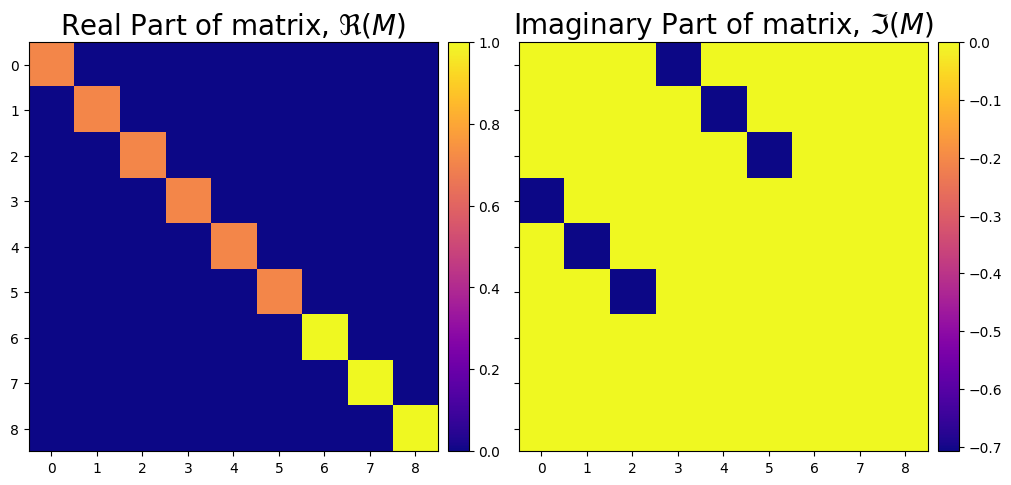

In [147]:
heatmap2d(Transmon_System.ideal_RXI(np.pi/2))

In [152]:
Transmon_System.fidelity(Transmon_System.ideal_RXI(np.pi/2), SX_q1_sol00.y[-1]).item()

0.997328188222685